In [10]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from nltk import word_tokenize,sent_tokenize
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from collections import OrderedDict
import pprint
import matplotlib.pyplot as plt
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from random import shuffle
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [11]:
df=pd.read_csv('final_data.csv')

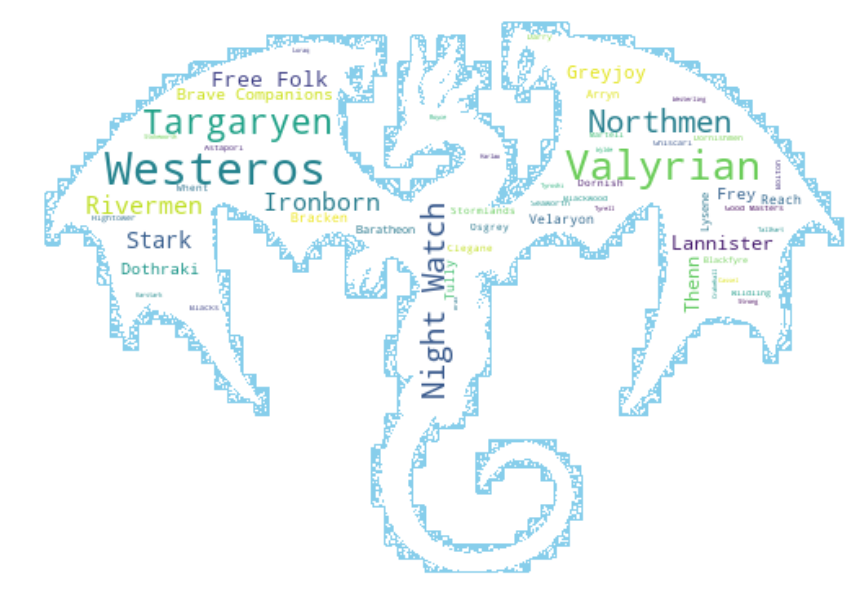

In [12]:
#draw the dragon picture
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
df_death=df[df['isAlive']==0]
culture=df_death['culture'].dropna().tolist()
houses=df_death['house'].dropna().tolist()
total = culture+houses
shuffle(total)
text = ' '.join(total)
text=text.replace('House','')
mask = np.array(Image.open("images/1.jpg"))
wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=STOPWORDS, contour_width=1, contour_color='skyblue')
wc.generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

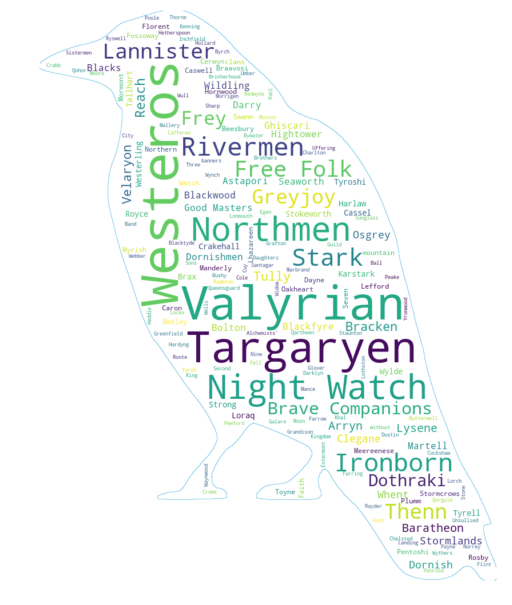

In [13]:
#draw the bird picture
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
mask = np.array(Image.open("images/crow.png"))
wc = WordCloud(background_color="white", max_words=2000, mask=mask,
               stopwords=STOPWORDS, contour_width=1, contour_color='skyblue')
wc.generate(text)

plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [7]:
def draw_cloud(max_=20):
    df=pd.read_csv('final_data.csv')
    df_death=df[df['isAlive']==0]
    houses=df_death['house'].dropna().tolist()
    #print(houses)
    from wordcloud import WordCloud
    import matplotlib.pyplot as plt
    %matplotlib inline
    from random import shuffle
    shuffle(houses)
    text = ' '.join(houses)
    text=text.replace('House','')
    wordcloud = WordCloud(background_color='white',max_words=max_).generate(text)
    plt.figure(figsize=[20,10])
    plt.axis('off')
    plt.imshow(wordcloud)
    return

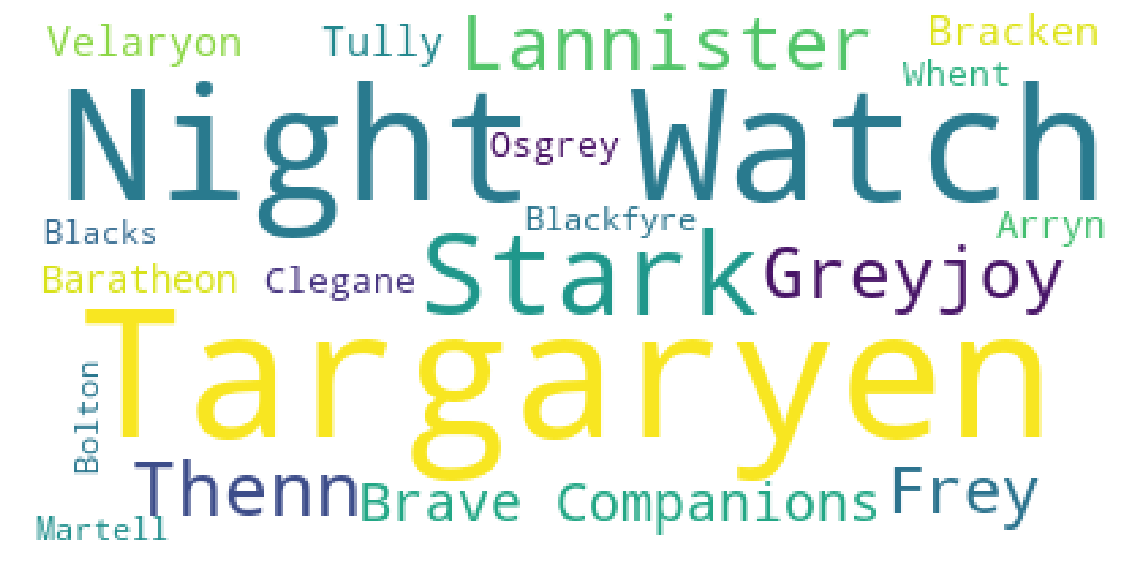

In [8]:
draw_cloud(max_=20)

In [9]:
def get_sentiment(name):
    response=requests.get("http://awoiaf.westeros.org/index.php/"+ name.replace(' ','_'))
    results_page=BeautifulSoup(response.content,'lxml')
    # paragraph = results_page.find('div',class_='mw-parser-output').find('p').get_text()
    para = results_page.find_all('p')
    para_list = list()
    for i in para:
        para_list.append(i.get_text())
    summary_sentences = []
    candidate_sentences = {}
    candidate_sentence_counts = {}
    text = r'{}'.format(para_list)
    # print(text.raw())
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    striptext = striptext.replace('\\n', ' ')
    striptext = striptext.replace('[]', ' ')
    words = word_tokenize(striptext)
    lowercase_words = [word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()] 
    
    def get_pos_neg_words():    
        def get_words(url):
            import requests
            words = requests.get(url).content.decode('latin-1')
            word_list = words.split('\n')
            index = 0
            while index < len(word_list):
                word = word_list[index]
                if ';' in word or not word:
                    word_list.pop(index)
                else:
                    index+=1
            return word_list

        #Get lists of positive and negative words
        p_url = 'http://ptrckprry.com/course/ssd/data/positive-words.txt'
        n_url = 'http://ptrckprry.com/course/ssd/data/negative-words.txt'
        positive_words = get_words(p_url)
        negative_words = get_words(n_url)
        return positive_words,negative_words
    
    positive_words,negative_words = get_pos_neg_words()
    
    def do_pos_neg_sentiment_analysis(text,debug=False):
        positive_words,negative_words = get_pos_neg_words()
        from nltk import word_tokenize
        results = list()
        cpos = cneg = lpos = lneg = 0
        for word in text:
            if word in positive_words:
                if debug:
                    print("Positive",word)
                cpos+=1
            if word in negative_words:
                if debug:
                    print("Negative",word)
                cneg+=1
        results.append((cpos/len(text),cneg/len(text)))
        return results
    pos = do_pos_neg_sentiment_analysis(lowercase_words,debug=False)[0][0]
    neg = do_pos_neg_sentiment_analysis(lowercase_words,debug=False)[0][1]
    return pos,neg

In [17]:
def main_chara_senti():
    df=pd.read_csv('final_data.csv')
    name_list=['Sansa Stark',  'Tyrion Lannister',  'Jon Snow', 'Daenerys Targaryen', 'Jaime Lannister',  'Bran Stark',  'Arya Stark',  'Cersei Lannister']
    sentiment=dict()
    for name in name_list:
        sentiment[name]=get_sentiment(name)
    positive=[]
    negative=[]
    for key in sentiment.keys():
        positive.append(sentiment[key][0])
        negative.append(sentiment[key][1])
        
    senti=pd.DataFrame(columns=['Character Name','Positive','Negative'])
    senti['Character Name']=name_list
    senti['Positive']=positive
    senti['Negative']=negative
    senti['Pos/Neg']=senti['Positive']/senti['Negative']
    
    return senti
        

In [20]:
sentiment=main_chara_senti()

In [21]:
def senti_graph(df):
    import plotly
    import plotly.plotly as py
    import plotly.graph_objs as go
    import os
    import plotly.io as pio
    from plotly.offline import iplot, init_notebook_mode
    init_notebook_mode(connected=True)
    plotly.tools.set_credentials_file(username='Carol_Sun', api_key='fXjezPBzwWsrA9HV363N')
    import seaborn as sns
    sns.set(style="whitegrid")
    trace1 = go.Scatter(
        x=df['Character Name'],
        y=df['Positive'],
        name='Positive',
    )
    trace2 = go.Scatter(
        x=df['Character Name'],
        y=df['Negative'],
        name='Negative',
        yaxis='y2'
    )
    data = [trace1, trace2]

    data = [trace1, trace2]
    layout = go.Layout(
        title='Sentiment Analysis',
        yaxis=dict(
            title='Positive'
        ),
        yaxis2=dict(
            title='Negative',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='styled histogram')
    return

In [22]:
senti_graph(sentiment)

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~Carol_Sun/0 or inside your plot.ly account where it is named 'styled histogram'


In [9]:
def get_emotions():
    nrc = "NRC-emotion-lexicon-wordlevel-alphabetized-v0.92.txt"
    count=0
    emotion_dict=dict()
    with open(nrc,'r') as f:
        all_lines = list()
        for line in f:
            #print(line,'\n',count)
            if count < 46:
                count+=1
                continue
            line = line.strip().split('\t')
            if int(line[2]) == 1:
    #             print(emotion_dict)
                if emotion_dict.get(line[0]):   
                    emotion_dict[line[0]].append(line[1])
    #                 print('add to',emotion_dict)
                else:
                    emotion_dict[line[0]] = [line[1]] 
    emotions = {x for y in emotion_dict.values() for x in y} 
    return emotion_dict

In [10]:
emotion_dict=get_emotions()

In [11]:
def emotion_analyzer(text,emotion_dict=emotion_dict):
    #Set up the result dictionary
    emotions = {x for y in emotion_dict.values() for x in y}  #这一行有点
    emotion_count = dict()
    for emotion in emotions:
        emotion_count[emotion] = 0       #创建emtion_count list 来数每一个emotion

    #Analyze the text and normalize by total number of words
    total_words = text     #split( 会把text 拆成 list of words)
    for word in total_words:
        if emotion_dict.get(word):       #== if emotion_dict.get(word) != None/有东西:
            for emotion in emotion_dict.get(word):       #把word 对应的emtion/s 都 数出来
                emotion_count[emotion] += 1/len(text)   #并记录到 每种emotions的 count中
    return emotion_count

In [12]:
def get_sentiment2(name,emotion_dict=emotion_dict):
    response=requests.get("http://awoiaf.westeros.org/index.php/"+ name.replace(' ','_'))
    results_page=BeautifulSoup(response.content,'lxml')
    # paragraph = results_page.find('div',class_='mw-parser-output').find('p').get_text()
    para = results_page.find_all('p')
    para_list = list()
    for i in para:
        para_list.append(i.get_text())
    summary_sentences = []
    candidate_sentences = {}
    candidate_sentence_counts = {}
    text = r'{}'.format(para_list)
    # print(text.raw())
    striptext = text.replace('\n\n', ' ')
    striptext = striptext.replace('\n', ' ')
    striptext = striptext.replace('\\n', ' ')
    striptext = striptext.replace('[]', ' ')
    words = word_tokenize(striptext)
    lowercase_words = [word.lower() for word in words
                      if word not in stopwords.words() and word.isalpha()]
    result = emotion_analyzer(lowercase_words,emotion_dict=emotion_dict)
    return result

In [17]:
name_list=['Sansa Stark',  'Tyrion Lannister',  'Jon Snow', 'Daenerys Targaryen', 'Jaime Lannister',  'Bran Stark',  'Arya Stark',  'Cersei Lannister']
dict2 = dict()
for i in name_list:
#     emotion_dict()
    dict_one = get_sentiment2(i,emotion_dict)
    dict2[i] = list(dict_one.values())
values = list(dict2.values())
#df2 = pd.DataFrame(dict2,columns=key2)
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Heatmap(z=values,
                   y=['Sansa Stark',  'Tyrion Lanni',  'Jon Snow', 'Daenerys', 'Jaime Lanni',  'Bran Stark',  'Arya Stark',  'Cersei Lanni'],
                   x=['surprise', 'sadness', 'fear', 'joy', 'trust', 'anger', 'disgust', 'negative', 'anticipation', 'positive'])
data=[trace]
layout = go.Layout(
    title='The Heatmap of Sentiment Analysis for Main Characters',
    xaxis=dict(
        title='Sentiment Value'
    ),
#     yaxis=dict(
#         title=
#     ),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='labelled-heatmap')
